<a href="https://colab.research.google.com/github/mauriciodev/spatialgeodesy/blob/main/exercises/Ex3_GNSS_observations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 3 - GNSS Observations

In this exercise we are going to download two observation RINEX files (versions 2 and 3) from IBGE's RBMC (Rede Brasileira de Monitoramento Contínuo), open with the Georinex library and plot the differences between the pseudodistance and carrier phase.
In this exercise you're going to use the RINEX version 2 code as example and write the version 3 code.

# Preparation

## Installing dependencies

In [17]:
#Python standard libraries
import os #File path operations.
import shutil #Shell operations. Unzipping, moving files, etc.
import urllib.request #Downloader.

#External libraries
import numpy as np #Numeric Python.
import pandas as pd #Python Data Analysis Library.
import matplotlib.pyplot as plt #Plots.
import xarray as xa #Multi dimension arrays. For georinex.   

In [18]:
# Installing the package that reads rinex and sp3 files
!pip install --upgrade pip
#!pip install git+https://github.com/geospace-code/georinex
!pip install git+https://github.com/breid-phys/georinex.git
# We are using a different georinex version 
# The speed for loading RINEX 3 files on current georinex is terrible.
import georinex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/breid-phys/georinex.git to /tmp/pip-req-build-06d02p9u
  Running command git clone --filter=blob:none --quiet https://github.com/breid-phys/georinex.git /tmp/pip-req-build-06d02p9u
  Resolved https://github.com/breid-phys/georinex.git to commit b76b692b8c497593e1c2b07fd26dc4f244dbe366
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Input parameters

Go to http://www.bdg.ibge.gov.br/appbdg/ , turn on RBMC in "Camadas" and choose one station. Change the value of the "station" variable for your chosen station.

In [19]:
#This is the reference time. We are going to use it to download the files.
t = pd.to_datetime('2023-01-01 02:00:01') 
station="RJNI" #This is the station. 

In [20]:
year = t.year
dayOfYear = t.day_of_year
twoDigitYear = t.year %100

#File name is based on the Day of Year
#formatiing with previous variables. Note the :03 on each variable to fill with leading zeros.
url_v2=f"https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/{year}/{dayOfYear:03}/{station.lower()}{dayOfYear:03}1.zip"
print("URL for the version 2 RINEX file:", url_v2)

URL for the version 2 RINEX file: https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/2023/001/rjni0011.zip


Please go to https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/ to understand how the RBMC data is provided.

## Downloading the receiver's observation file

In [21]:
#splitting the file name from the URL
obsRinexFile_v2=os.path.split(url_v2)[1] 
urllib.request.urlretrieve(url_v2, obsRinexFile_v2) #download the file saving as the name in obsRinexFile_v2
print(obsRinexFile_v2)

rjni0011.zip


# Rinex version 2 file

In [22]:
# the ! prefix runs the commands on a linux shell. So we can use both python and shell commands on this notebook.
import shutil #Shell operations. Unzipping, moving files, etc.
shutil.unpack_archive(obsRinexFile_v2) 
uncompressed=obsRinexFile_v2[:-3]

for f in os.listdir(): print(f) #listing files in the current directory

.config
RJNI00BRA_R_20230010000_01D_15S_MO.crx.gz
rjni0011.23l
rjni0011.23n
rjni0011.zip
rjni0011.23d
rjni0011.23g
sample_data


In [23]:
obsFile_v2=obsRinexFile_v2[:-3]+f"{twoDigitYear}d"
print("Observation file: ", obsFile_v2)

Observation file:  rjni0011.23d


## Showing the first 30 lines of the observation file

In [24]:
with open(obsFile_v2) as f:
  #printing the first 30 lines of the rinex file. 
  print(''.join(f.readlines()[:30])) 
  #Note that f.readlines() returns a list. 

1.0                 COMPACT RINEX FORMAT                    CRINEX VERS   / TYPE
RNX2CRX ver.4.0.8                       02-Jan-23 04:54     CRINEX PROG / DATE
     2.11           OBSERVATION DATA    M (MIXED)           RINEX VERSION / TYPE
teqc  2019Feb25                         20230102 04:53:56UTCPGM / RUN BY / DATE
RBMC                IBGE                                    OBSERVER / AGENCY
5750R51585          TRIMBLE NETR9       5.56                REC # / TYPE / VERS
1551129599          TRM115000.00    NONE                    ANT # / TYPE
        0.0080        0.0000        0.0000                  ANTENNA: DELTA H/E/N
  4289663.4011 -4018945.7498 -2467135.8382                  APPROX POSITION XYZ
    17    C1    C2    C5    C7    C8    L1    L2    L5    L7# / TYPES OF OBSERV
          L8    P1    P2    S1    S2    S5    S7    S8      # / TYPES OF OBSERV
    15.0000                                                 INTERVAL
CODIGO: 96361    Estacao: Niteroi UFF                     

Note that on RINEX 2 the file ending with "d" is the multignss data, but it doesn't have all the systems.
We can't read anything because it's in Hatanaka compressed RINEX format. Converting it to regular RINEX files require the hatanaka program, that is included with Georinex.

In [25]:
obsData=georinex.load(obsFile_v2)
obsData

<xarray.Dataset>
Dimensions:  (time: 5760, sv: 81)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01 ... 2023-01-01T23:59:45
  * sv       (sv) <U3 'E01' 'E02' 'E03' 'E04' 'E05' ... 'R21' 'R22' 'R23' 'R24'
Data variables: (12/17)
    C1       (time, sv) float64 2.809e+07 nan nan 2.632e+07 ... nan nan nan nan
    C2       (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    C5       (time, sv) float64 2.809e+07 nan nan 2.632e+07 ... nan nan nan nan
    C7       (time, sv) float64 2.809e+07 nan nan 2.632e+07 ... nan nan nan nan
    C8       (time, sv) float64 2.809e+07 nan nan 2.632e+07 ... nan nan nan nan
    L1       (time, sv) float64 1.476e+08 nan nan 1.383e+08 ... nan nan nan nan
    ...       ...
    P2       (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    S1       (time, sv) float64 40.1 nan nan 45.3 45.1 ... nan nan nan nan nan
    S2       (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    S5       (time, sv) float64 41.1 nan nan 45.7 45.8 ... nan nan nan nan nan
    S7       (time, sv) float64 40.0 nan nan 44.8 45.5 ... nan nan nan nan nan
    S8       (time, sv) float64 44.4 nan nan 48.8 49.0 ... nan nan nan nan nan
Attributes:
    version:          1.0
    interval:         15.0
    rinextype:        obs
    fast_processing:  1
    time_system:      GPS
    filename:         rjni0011.23d
    rxmodel:          TRIMBLE NETR9
    position:         [4289663.4011, -4018945.7498, -2467135.8382]

Take your time to inspect the data above. \
The "coordinates" show that observations can be selected using sv (spatial vehicle) and time. \
The "Data variables" show that we have psudoranges (Ex.: C1, P1), carrier phase (Ex.: L1) and signal strength (Ex.: S1)
Note that because this is a multiGNSS file, there is a lot of nan (missing values). For example, GPS satellites only provide data on bands 1, 2 and 5, so C7 measures will be nan.

## Plotting GPS satellite 1 measures

Here we are going to filter the observation file and select only one vehicle.

In [26]:
sv='G01'
obsData.sel(sv=sv).C1

<xarray.DataArray 'C1' (time: 5760)>
array([23474275.25 , 23483474.602, 23492674.   , ..., 23597335.422,
       23606522.766, 23615706.406])
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01 ... 2023-01-01T23:59:45
    sv       <U3 'G01'

[]

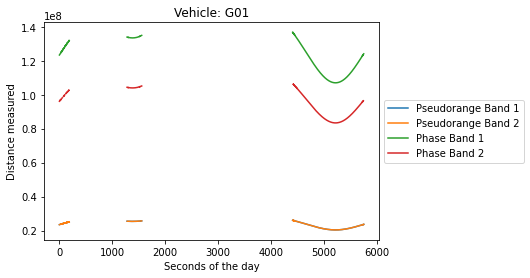

In [27]:
sv='G01'
plt.plot(obsData.sel(sv=sv).C1, label="Pseudorange Band 1")
plt.plot(obsData.sel(sv=sv).C2, label="Pseudorange Band 2")
plt.plot(obsData.sel(sv=sv).L1, label="Phase Band 1")
plt.plot(obsData.sel(sv=sv).L2, label="Phase Band 2")
plt.xlabel("Seconds of the day")
plt.ylabel("Distance measured")
plt.title(f"Vehicle: {sv}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.plot()

[]

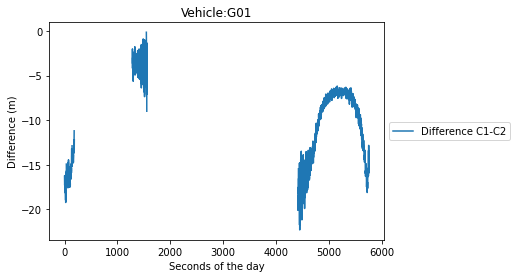

In [28]:
sv='G01'
plt.plot(obsData.sel(sv=sv).C1-obsData.sel(sv=sv).C2, label="Difference C1-C2")
plt.xlabel("Seconds of the day")
plt.ylabel("Difference (m)")
plt.title(f"Vehicle:{sv}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.plot()

# **Rinex version 3 file (Please fill this part)**

In [29]:
url_v3=f"https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados_RINEX3/{year}/{dayOfYear:03}/{station.upper()}00BRA_R_{year}{dayOfYear:03}0000_01D_15S_MO.crx.gz"
print("URL for the version 3 RINEX file:", url_v3)

URL for the version 3 RINEX file: https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados_RINEX3/2023/001/RJNI00BRA_R_20230010000_01D_15S_MO.crx.gz


In [30]:
obsRinexFile_v3=os.path.split(url_v3)[1] 
urllib.request.urlretrieve(url_v3, obsRinexFile_v3) #download the file saving as the name in obsRinexFile_v3
print(obsRinexFile_v3)

RJNI00BRA_R_20230010000_01D_15S_MO.crx.gz


In [31]:
obsData=georinex.load(obsRinexFile_v3) 
obsData

<xarray.Dataset>
Dimensions:  (sv: 96, time: 5760)
Coordinates:
  * sv       (sv) <U3 'C11' 'C12' 'C14' 'C19' 'C20' ... 'R21' 'R22' 'R23' 'R24'
  * time     (time) datetime64[ns] 2023-01-01 ... 2023-01-01T23:59:45
Data variables: (12/39)
    C1C      (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    L1C      (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    S1C      (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    C1P      (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    L1P      (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    S1P      (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    ...       ...
    C7X      (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    L7X      (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    S7X      (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    C8X      (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    L8X      (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    S8X      (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    version:          3.05
    interval:         15.0
    rinextype:        obs
    fast_processing:  1
    time_system:      GPS
    filename:         RJNI00BRA_R_20230010000_01D_15S_MO.crx.gz
    position:         [4289663.4011, -4018945.7498, -2467135.8382]

Plot the same graphs that we plotted with the Version 2 file.